# 2. Topologycal Analysis

In [1]:
import praw
import pandas as pd
import json
from datetime import datetime
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import networkx as nx

# load
df_general = pd.read_csv('../data/aot_general.csv')
df_ending = pd.read_csv('../data/aot_ending.csv')
df_general['created_utc'] = pd.to_datetime(df_general['created_utc'])
df_ending['created_utc'] = pd.to_datetime(df_ending['created_utc'])

In [2]:
# login with your reddit credentials

def login_reddit(reddit_credentials):
    with open(reddit_credentials, "r") as f:
        credentials = json.load(f)

    reddit = praw.Reddit(
        client_id=credentials['CLIENT_ID'],
        client_secret=credentials['SECRET_TOKEN'],
        password=credentials['PASSWORD'],
        user_agent='Tutorial by /user/SMA202324',
        username=credentials['USERNAME'],
        check_for_async=False
    )

    if reddit.read_only:
        print("Reddit login failed. Please check your credentials.")
        return None
    else:
        print(f"🤖 Reddit login successful. Welcome {reddit.user.me()}")
        return reddit
    
reddit_credentials = "../data/redditCredentials.json"
reddit = login_reddit(reddit_credentials)

Version 7.7.1 of praw is outdated. Version 7.8.1 was released Friday October 25, 2024.


🤖 Reddit login successful. Welcome Disastrous_Walk_7254


In [3]:
df_general.head()

,author,author_flair_text,clicked,comments,created_utc,distinguished,edited,id,is_original_content,is_self,...,poll_data,saved,score,selftext,spoiler,stickied,subreddit,title,upvote_ratio,url
0,FoxicalOW,NaN,False,<praw.models.comment_forest.CommentForest obje...,2021-01-14 16:21:28,NaN,False,kx7nlm,True,False,...,NaN,False,29142,NaN,False,False,attackontitan,I built Shiganshina in Minecraft 1:1,0.99,https://i.redd.it/zlx4dtb7fbb61.jpg
1,kinekocat,Potato Girl Enjoyer :sasha_potato:,False,<praw.models.comment_forest.CommentForest obje...,2025-02-17 20:25:34,NaN,False,1irsbx6,False,False,...,NaN,False,26708,NaN,False,False,attackontitan,How do I even react to this??,0.98,https://i.redd.it/c7jyj8d23rje1.jpeg
2,ProfessorRigby,NaN,False,<praw.models.comment_forest.CommentForest obje...,2021-01-25 07:36:27,NaN,False,l4hxj7,False,False,...,NaN,False,24543,NaN,False,False,attackontitan,"Dad: ""Stop watching those stupid cartoons!"" Tw...",0.99,https://v.redd.it/7ewif8yjbfd61
3,NaN,NaN,False,<praw.models.comment_forest.CommentForest obje...,2021-10-05 22:44:40,NaN,False,q2569s,False,False,...,NaN,False,23331,NaN,False,False,attackontitan,well?,0.97,https://i.redd.it/ai437vhk1pr71.jpg
4,Psplus01,NaN,False,<praw.models.comment_forest.CommentForest obje...,2021-02-01 11:14:59,NaN,False,la0032,False,False,...,NaN,False,22645,NaN,False,False,attackontitan,Eren vs Annie in a nutshell,0.98,https://i.redd.it/oulo1tczcue61.jpg


In [5]:
def get_comments(df):
    # get comments till the third level

    res = []
    for index, i in df.iterrows():
        # Find author and comments
        sub_auth= i['author']
        sub= reddit.submission(i['id'])
        sub.comments.replace_more(limit=20)
        # Extract author for each comment
        for top_level_comment in sub.comments:
            # author of the top level comment
            top_l_auth = top_level_comment.author
            res.append({
                'parent': str(sub_auth), 
                'child': str(top_l_auth), 
                'text_comment': top_level_comment.body
            })
            # replies - second level comments
            for second_level_comment in top_level_comment.replies:
                # again we get the authors of the replies and create the pairs we are interested in 
                sec_l_auth = second_level_comment.author
                res.append({
                    'parent': str(top_l_auth), 
                    'child': str(sec_l_auth), 
                    'text_comment': second_level_comment.body
                })
                # replies of the repleis - third level comments
                for third_level_comment in second_level_comment.replies:
                    res.append({
                        'parent': str(sec_l_auth), 
                        'child': str(third_level_comment.author), 
                        'text_comment': third_level_comment.body
                    })
    return pd.DataFrame(res)

In [6]:
comments_df_general = get_comments(df_general)
comments_df_general.to_csv('../data/comments_graph_general.csv', index=False)
comments_df_ending = get_comments(df_ending)
comments_df_ending.to_csv('../data/comments_graph_ending.csv', index=False)
print("length of comments df general: ", len(comments_df_general))
print("length of comments df ending: ", len(comments_df_ending))

length of comments df general:  42661
length of comments df ending:  23475


In [20]:
comments_df_ending.head()

,parent,child,text_comment
0,joaopaulofoo,Umer123321,Armin Mikasa and Eren have finally seen the Sea.
1,Umer123321,None,"It was kinda bittersweet for Eren, but I liked..."
2,None,s4l4o6t3h,It being bittersweet for Eren was honestly my ...
3,None,Umer123321,We wait for a year for the ending to all of this
4,Umer123321,ashai1994,How? where


In [3]:
# load
comments_df_general = pd.read_csv('../data/comments_graph_general.csv')
comments_df_ending = pd.read_csv('../data/comments_graph_ending.csv')

print("None/NaN values in comments_df_general:")
print(comments_df_general.isnull().sum())
print(f"Total None/NaN values: {comments_df_general.isnull().sum().sum()}")

print("\nNone/NaN values in comments_df_ending:")
print(comments_df_ending.isnull().sum())
print(f"Total None/NaN values: {comments_df_ending.isnull().sum().sum()}")

None/NaN values in comments_df_general:
parent          6326
child           6787
text_comment       0
dtype: int64
Total None/NaN values: 13113

None/NaN values in comments_df_ending:
parent          1904
child           3763
text_comment       0
dtype: int64
Total None/NaN values: 5667


## General

In [6]:
G = nx.Graph()
for index, r in comments_df_general.iterrows():
    G.add_edge(r['parent'], r['child'])

print(f"Size of the graph: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Size of the graph: 17766 nodes and 30109 edges


In [7]:
largest_cc = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc).copy()
print(f"Size of the largest connected component: {G_lcc.number_of_nodes()} nodes and {G_lcc.number_of_edges()} edges")

Size of the largest connected component: 17766 nodes and 30109 edges


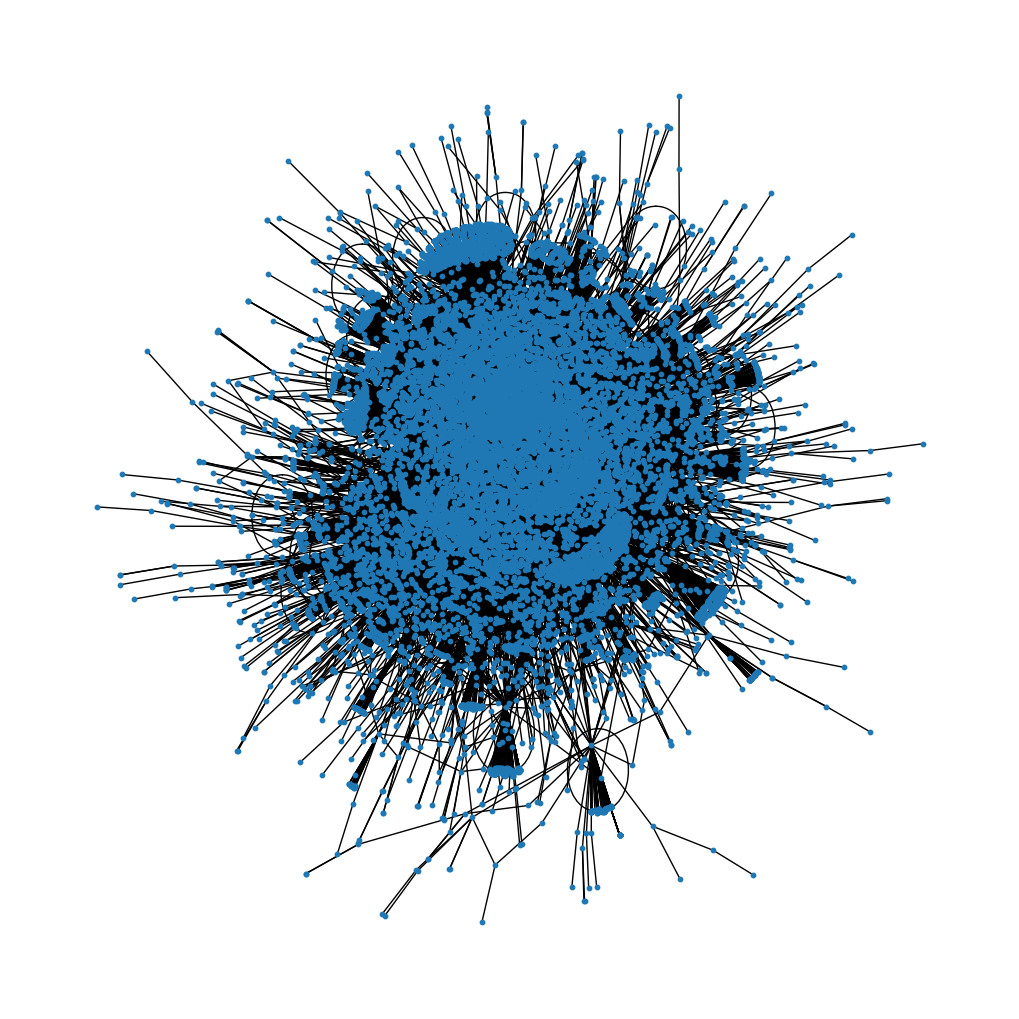

In [9]:
plt.figure(figsize=(10,10))
nx.draw_spring(G_lcc, node_size=10, with_labels=False)
plt.show()

# Ending

In [6]:
G = nx.Graph()
for index, r in comments_df_ending.iterrows():
    if (r['parent'] == 'None' or r['child'] == 'None' or 
        r['parent'] == 'nan' or r['child'] == 'nan' or
        pd.isna(r['parent']) or pd.isna(r['child'])):
        # Skip rows with None, 'nan' strings, or actual NaN values
        continue
    G.add_edge(r['parent'], r['child'])

print(f"Size of the graph: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Size of the graph: 9771 nodes and 13948 edges


In [7]:
G.remove_edges_from(list(nx.selfloop_edges(G)))
print(f"Size of the graph: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Size of the graph: 9771 nodes and 13881 edges


In [8]:
largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()
print(f"Size of the largest connected component: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Size of the largest connected component: 9720 nodes and 13850 edges


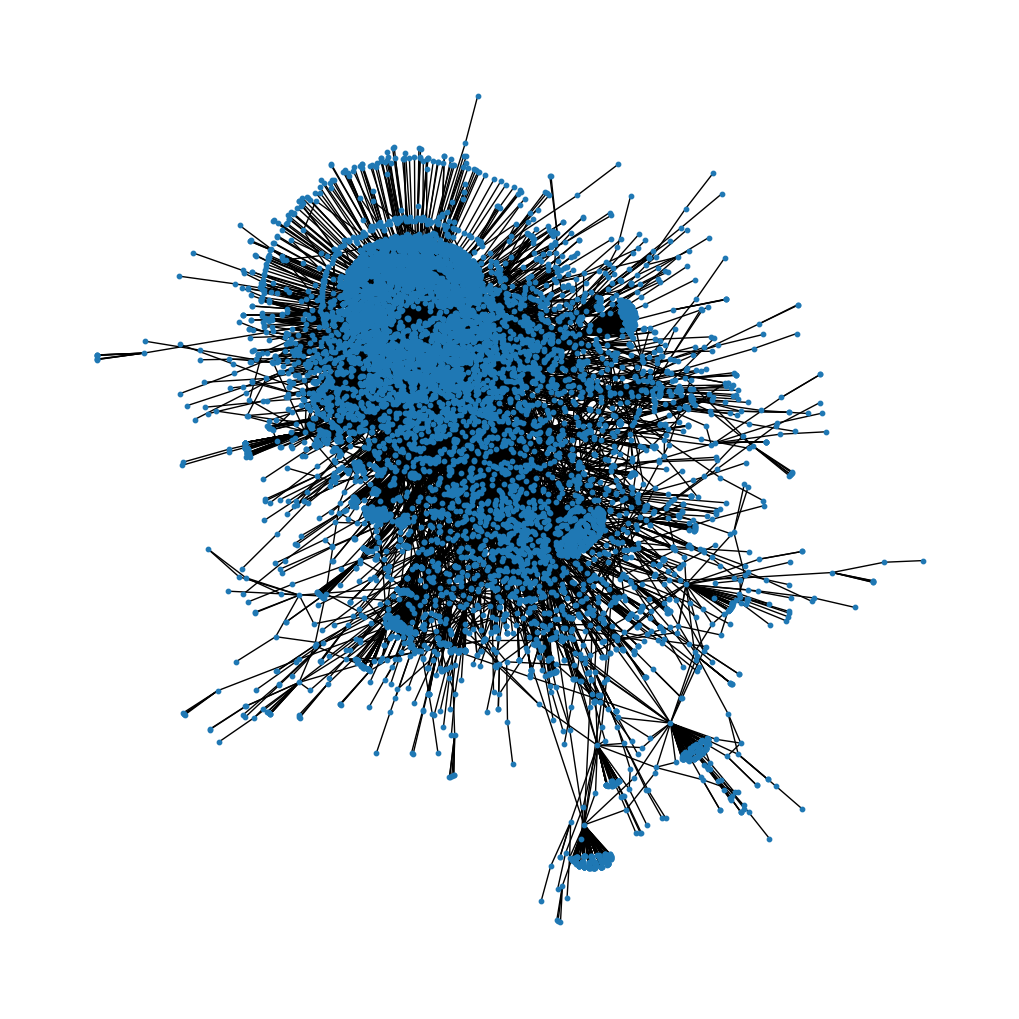

In [9]:
plt.figure(figsize=(10,10))
nx.draw_spring(G, node_size=10, with_labels=False)
plt.show()

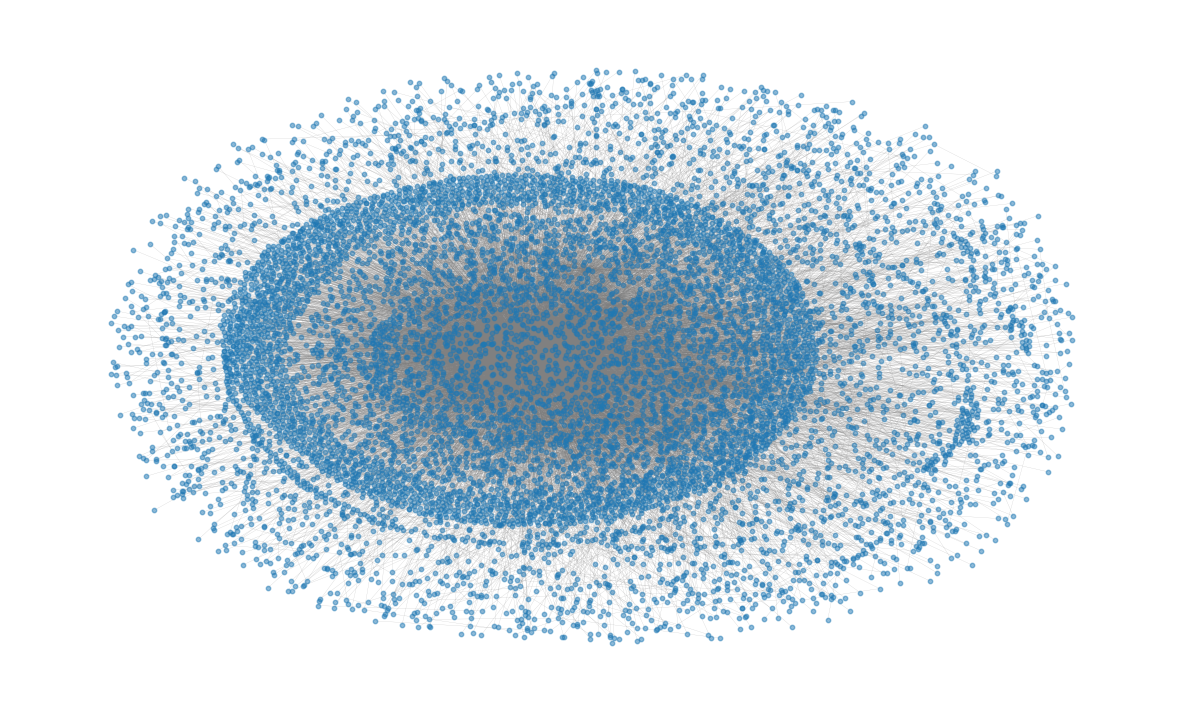

: 

In [ ]:
pos = nx.spring_layout(G, k=0.1, iterations=50, seed=42)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, node_size= 10, with_labels= False, width=0.15, alpha=0.5, edge_color='gray')

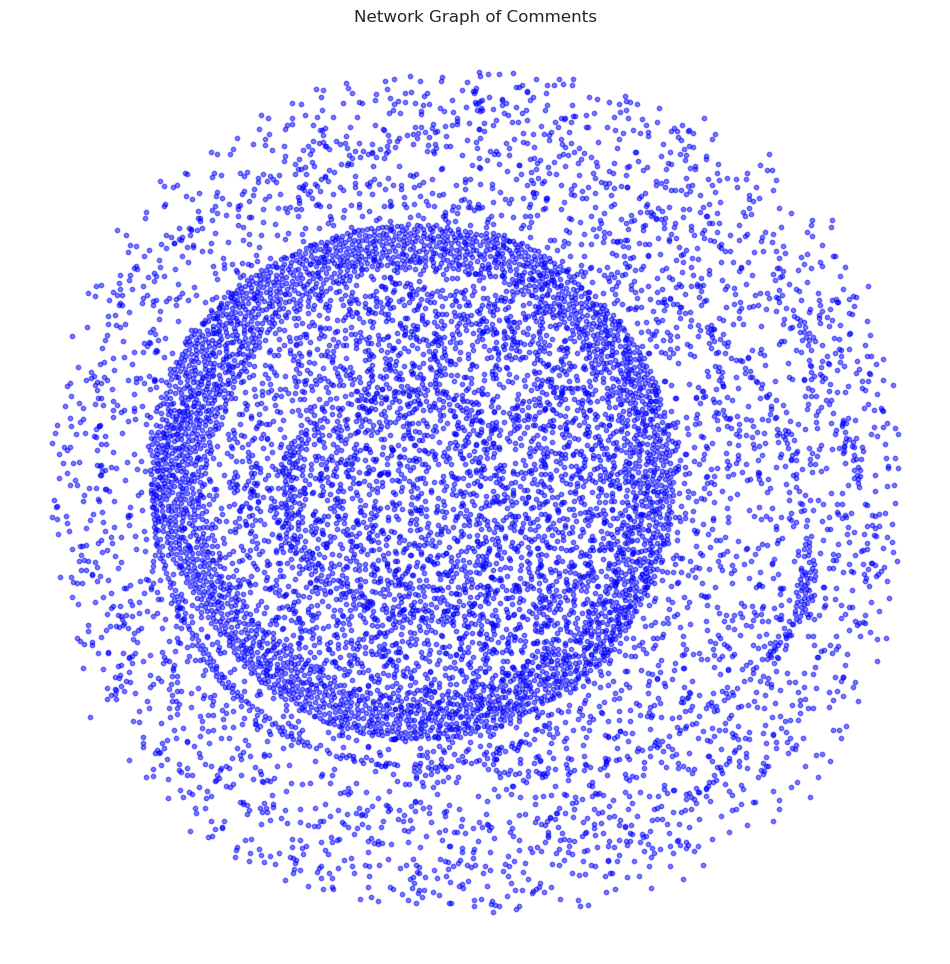

In [25]:
pos = nx.spring_layout(G, k=0.1, iterations=50, seed=42)

plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='blue', alpha=0.5)
plt.title("Network Graph of Comments")
plt.axis('off')
plt.show()

In [ ]:
print("Number of self loops:", len(list(nx.selfloop_edges(G))))
print("Radius: ", nx.radius(G))
print("Diameter: ", nx.diameter(G))
print("Average shortest path length: ", nx.average_shortest_path_length(G))
print("Average clustering coefficient: ", nx.average_clustering(G))
print("Density: ", nx.density(G))

Number of self loops: 0
Radius:  5
Diameter:  10
Average shortest path length:  3.338452863407769
Average clustering coefficient:  0.14017103418573346
Density:  0.000306929651668892


: 

In [24]:
dg_cen = nx.degree_centrality(G)
dg_cen2= pd.DataFrame(dg_cen.items(), columns=['node','dg_c'])

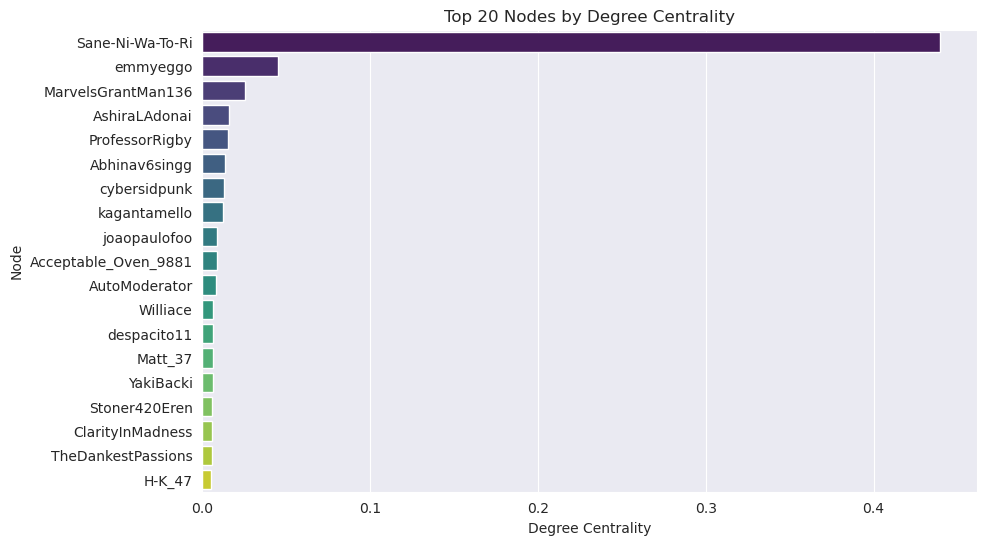

In [26]:
dg_cen2 = dg_cen2.sort_values(by='dg_c', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='dg_c', y='node', data=dg_cen2.head(20), palette='viridis', hue='node', legend=False)
plt.title("Top 20 Nodes by Degree Centrality")
plt.xlabel("Degree Centrality")
plt.ylabel("Node")
plt.show()


In [27]:
# Count the number of None/NaN values in the comments_df_ending dataframe
none_count_ending = comments_df_ending.isnull().sum().sum()
none_count_general = comments_df_general.isnull().sum().sum()

print(f"Total None/NaN values in comments_df_ending: {none_count_ending}")
print(f"Total None/NaN values in comments_df_general: {none_count_general}")

# Count None/NaN values by column
print("\nNone/NaN values by column in comments_df_ending:")
print(comments_df_ending.isnull().sum())

print("\nNone/NaN values by column in comments_df_general:")
print(comments_df_general.isnull().sum())

Total None/NaN values in comments_df_ending: 5667
Total None/NaN values in comments_df_general: 13113

None/NaN values by column in comments_df_ending:
parent          1904
child           3763
text_comment       0
dtype: int64

None/NaN values by column in comments_df_general:
parent          6326
child           6787
text_comment       0
dtype: int64


---

Ending round 2
